# Supernova distances and redshift 2

Measuring the cosmological relationship between distance and redshift is a crucial task in cosmology. We can use **Standard Candle**, i.e. astrophysical objects with a known brightness. At high redshift we use **Type Ia Supernovae**, a type of supernova produced in the merger od two white dwarfs.

The apparent magnitude $m$ of an astronomical source in a photometric bandpass is defined to be the ratio of the apparent flux of that source to the apparent flux of the bright star Vega, through that bandpass.

The **distance modulus** $\mu$ is defined by:

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

where $ d_{L}$ is the luminosity distance. 


In [2]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['font.size'] = 15

(35.0, 50.0)

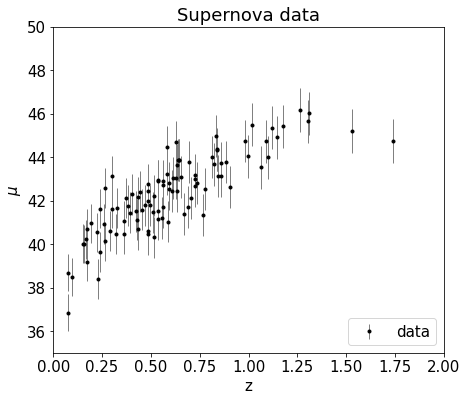

In [3]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Supernova data')
plt.xlim(0,2)
plt.ylim(35,50)

Let's perform a **data-driven** regression on these data.

## Gaussian Process Regression

For our **GPR** we decide to use a radial basis function Kernel: 

$$ K(x_i, x_j) = exp( -\frac{d(x_i,x_j)^2}{2l^2} ), $$

with $d$ = eucledian distance and $l$ = length scale parameter.

We use the tool **GaussianProcessRegressor** from sklearn.

**Alpha** is the value added to the diagonal of the kernel matrix during fitting.

The parameter od the kernel are determined using cross-validation

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import train_test_split

z_grid = np.linspace(0.01, 2, 1000)

z_train, z_test, mu_train, mu_test = train_test_split(z_sample[:, None], mu_sample, test_size=0.3, shuffle=False) #shuffle false to know the errors to put inside

#kernel = 1* kernels.RBF( length_scale = 10, length_scale_bounds=(1e-2, 1e-2))
kernel = ConstantKernel() * RBF() 

gp_rb = GaussianProcessRegressor(kernel = kernel, alpha = dmu[:70]**2) #only the first 70 elements of dmu correspond to the train data
gp_rb.fit(z_train, mu_train)
print('Optimazed Kernel:' ,gp_rb.kernel_)

mu_pred_rb, sigma_pred_rb = gp_rb.predict(z_grid[:, np.newaxis],return_std=True)

Optimazed Kernel: 30.2**2 * RBF(length_scale=3.59)


(35.0, 50.0)

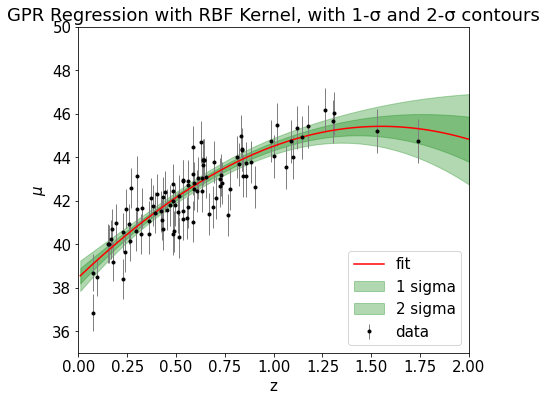

In [5]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z_grid, mu_pred_rb, color='r',label='fit')
plt.fill_between(z_grid, mu_pred_rb - 1 * sigma_pred_rb, mu_pred_rb + 1 * sigma_pred_rb, color='green', alpha=0.3, label = '1 sigma')
plt.fill_between(z_grid, mu_pred_rb - 2 * sigma_pred_rb, mu_pred_rb + 2 * sigma_pred_rb, color='green', alpha=0.3, label = '2 sigma')

plt.title('GPR Regression with RBF Kernel, with 1-σ and 2-σ contours')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

## Theoretical function 

We assume our universe is described by $\Lambda$CDM cosmological model, i.e. dark energy and matter are the relevant component.

With this hyphothesis the distance modulus $\mu$ can be written as follow: 

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

with $H_0$ is the Hubble parameter today, $\Omega_m$ is the mass density parameter and $\Omega_\Lambda $  is the dark energy density parameter. 

Astropy provides a class to obtain cosmological result.

In [6]:
from astropy.cosmology import LambdaCDM

def distance(z, H0, Om):
    Universe = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return Universe.distmod(z).value #I only care about values without physical units

## Scipy Curve-fit

Since I know the theoretical form of the model I can perform parametric fit.

Now we use **scipy.optimize.curve_fit**, which implement the **LM (Levenberg-Marquardt) algorithm** to optimize the 
maximum likelihood estimation.

In [7]:
from scipy.optimize import curve_fit
from astropy.cosmology import WMAP9 as cosmo

par_guess = [70, 0.27] #our guess for the parameter from theory 
popt, pcov = curve_fit(distance, z_sample, mu_sample, sigma = dmu, p0 = par_guess ) #including error for curve_fit

print('Constant from astropy.cosmology: H0 =  %.3f, Omega_m = %.3f' %(cosmo.H(0).value, cosmo.Om0))
print('Constant from the Curve fit: H0 =  %.3f, Omega_m = %.3f' %(popt[0], popt[1]))
print('Covariance matrix:\n' , pcov)

Constant from astropy.cosmology: H0 =  69.320, Omega_m = 0.286
Constant from the Curve fit: H0 =  68.521, Omega_m = 0.345
Covariance matrix:
 [[55.89187679 -1.95106264]
 [-1.95106264  0.08020627]]


(35.0, 50.0)

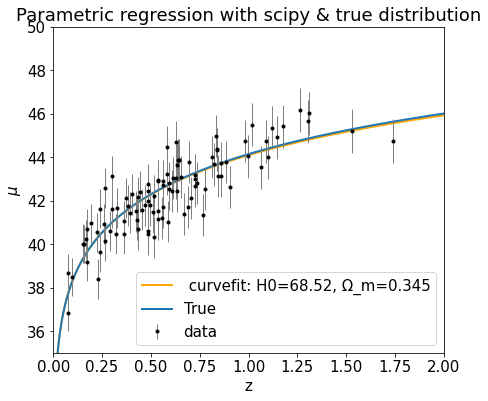

In [8]:
plt.plot(z_grid, distance(z_grid, *popt),label=' curvefit: H0=%.2f, Ω_m=%.3f' % tuple(popt), color = 'orange', linewidth= 2)
plt.plot(z_grid, distance(z_grid,  cosmo.H(0).value, cosmo.Om0), label = 'True', linewidth= 2)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.title('Parametric regression with scipy & true distribution')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)


## MCMC

Since we know the theoretical form of the model, we can use the **MCMC** techniques to sample the parameter space and find the optimal model parameters.

In [9]:
import emcee

H_min, H_max = 30.0, 100.0
Omega_m_min, Omega_m_max = 0.1, 1.0

def distance_emcee(z, x):
    H0, Om = x 
    Universe = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return Universe.distmod(z).value 

def LogLikelihood(x, z, mu, dmu):   
    if x[1]<0:
        return -np.inf
    else:
        model = distance_emcee(z, x)
    return -0.5*np.sum((mu-model)**2 / dmu**2 + 2*np.log(dmu))

def LogPrior(x):
    H0, Omega_m = x
    if H_min < H0 < H_max and Omega_m_min < Omega_m < Omega_m_max:
        return 0.0 + 0.0 
    else: 
        return -np.inf

def myLogPosterior(x, z, mu, dmu):
    lp = LogPrior(x)
    if not np.isfinite(lp):
        return -np.inf
    else: 
        return LogLikelihood(x, z, mu, dmu) + LogPrior(x)


In [10]:
ndim = 2  # number of parameters in the model
nwalkers = 12  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(6)
starting_guesses = par_guess + np.random.random((nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[z_sample, mu_sample, dmu])
sampler.run_mcmc(starting_guesses, nsteps, progress = True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

C:\Users\LEONARDO\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


done


In [11]:
tau = sampler.get_autocorr_time()
print(tau)
thin = tau.astype(int) +1 
print(thin)

new_samples = sampler.get_chain(discard=int(burn/max(thin)), thin = max(thin), flat=True)
print(new_samples.shape)

[41.55349915 41.26027871]
[42 42]
(2844, 2)


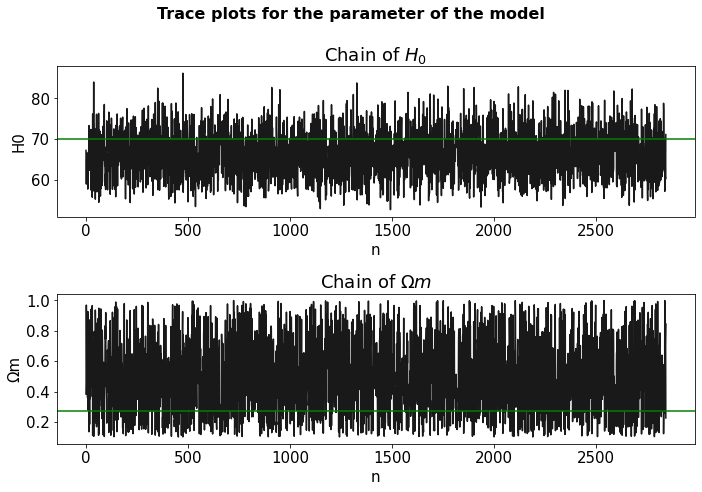

In [12]:
fig, ax= plt.subplots(2, figsize=(10, 7))
ax[0].plot(new_samples[:,0], color='black', alpha = 0.9)
ax[1].plot(new_samples[:,1], color='black', alpha = 0.9)

#initial guesses lines
ax[0].axhline(par_guess[0], color='green')
ax[1].axhline(par_guess[1], color='green')

fig.suptitle('Trace plots for the parameter of the model', fontsize = 16, fontweight="bold")

ax[0].set_xlabel('n')
ax[0].set_ylabel('H0')
ax[0].set_title('Chain of $H_{0}$')


ax[1].set_xlabel('n')
ax[1].set_ylabel('Ωm')
ax[1].set_title('Chain of $Ωm$')


fig.tight_layout()
plt.show()

Text(0.5, 1.04, 'Corner plot 2-D parameter space')

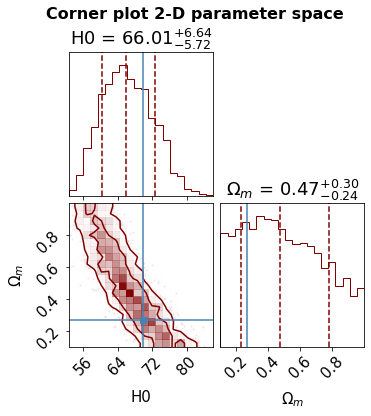

In [13]:
import corner

labels = ["H0", r"$\Omega_{m}$"]
fig = corner.corner(new_samples, labels=labels, levels=[0.68,0.95], quantiles =[0.16,0.5,0.84], show_titles= True, color = 'maroon', truths = par_guess);
fig.suptitle('Corner plot 2-D parameter space', fontsize = 16, fontweight="bold",  y=1.04)

In [14]:
log_probabilities_mcmc = sampler.get_log_prob(discard=int(burn/max(thin)), thin = max(thin), flat=True)

max_posterior_idx = np.argmax(log_probabilities_mcmc)
max_posterior_mcmc = new_samples[max_posterior_idx]
print('Constant from the MCMC: H0 =  %.2f, Omega_m = %.3f' %(max_posterior_mcmc[0], max_posterior_mcmc[1]))

Constant from the MCMC: H0 =  68.59, Omega_m = 0.345


(35.0, 50.0)

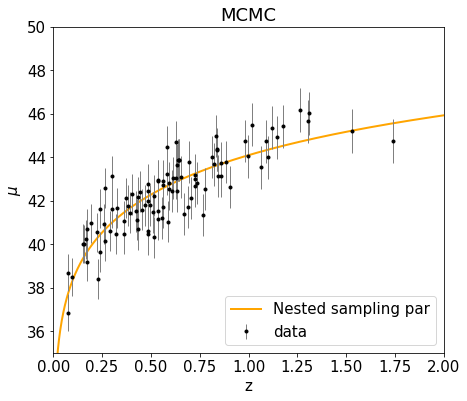

In [15]:
plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['font.size'] = 15
plt.plot(z_grid, distance(z_grid, max_posterior_mcmc[0], max_posterior_mcmc[1]),label='Nested sampling par', color = 'orange', linewidth= 2)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.title('MCMC')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)


## Nested Sampling

Here we perform the same analysis with the **Nested Sampling** algorithm.

In [16]:
import dynesty
from scipy import stats, interpolate
import scipy.stats
from scipy import optimize


H_min, H_max = 30.0, 100.0
Omega_m_min, Omega_m_max = 0.1, 1.0


def loglike_(x):
    model = distance_emcee(z_sample, x)
    logL = -0.5*np.sum((mu_sample-model)**2 / dmu**2)
    
    if not np.isfinite(logL):
        logL = -1e300
    
    return logL
 
# Define our uniform prior
def ptform_(u):
    
    x = np.array(u)  # copy u, u belongs to the hypercube [0,1]

    x[0] = scipy.stats.uniform(loc=H_min,scale=H_max-H_min).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=Omega_m_min,scale=Omega_m_max-Omega_m_min).ppf(u[1])

    return x

In [17]:
# "Static" nested sampling

sampler = dynesty.NestedSampler(loglike_, ptform_, ndim, nlive=300) #nlive = 250 by default
sampler.run_nested()
sresults = sampler.results

1139it [00:42, 26.57it/s, +300 | bound: 1 | nc: 1 | ncall: 11312 | eff(%): 13.068 | loglstar:   -inf < -46.385 <    inf | logz: -48.877 +/-  0.069 | dlogz:  0.001 >  0.309]


We plot a summary of the run.

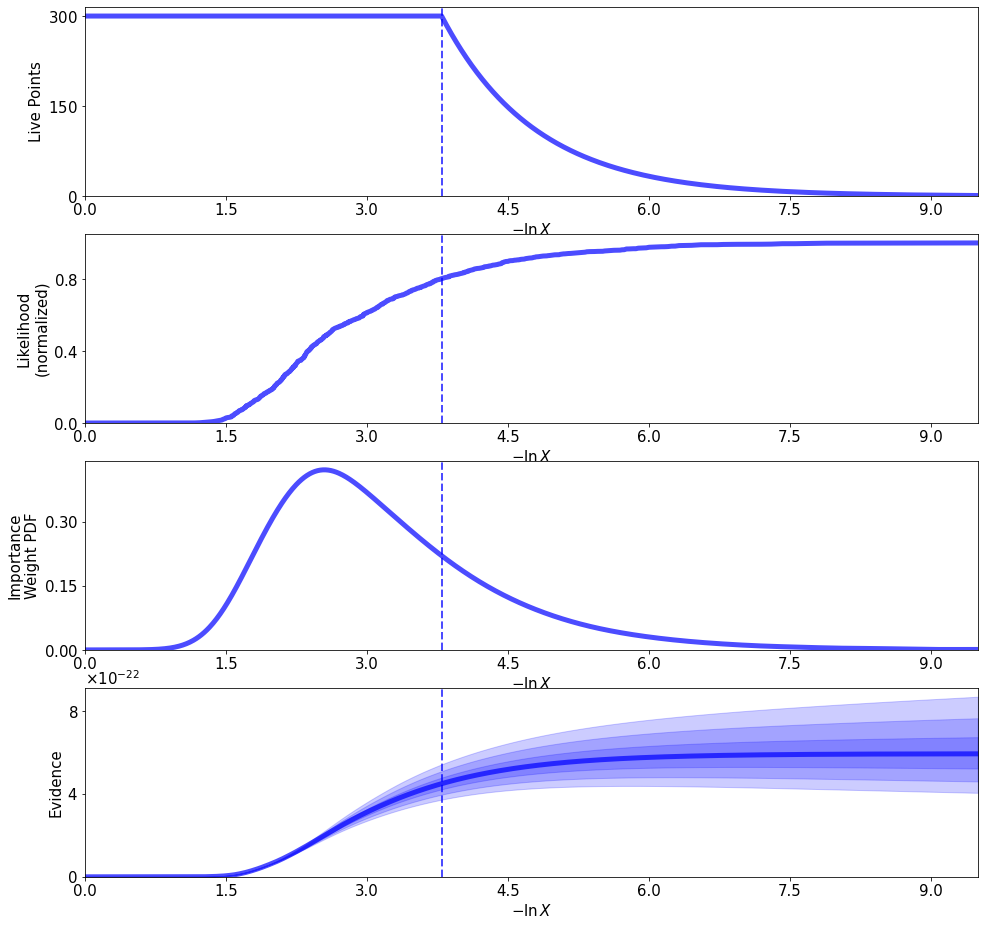

In [18]:
plt.rcParams['figure.figsize'] = [2, 2]
from dynesty import plotting as dyplot
rfig, raxes = dyplot.runplot(sresults)

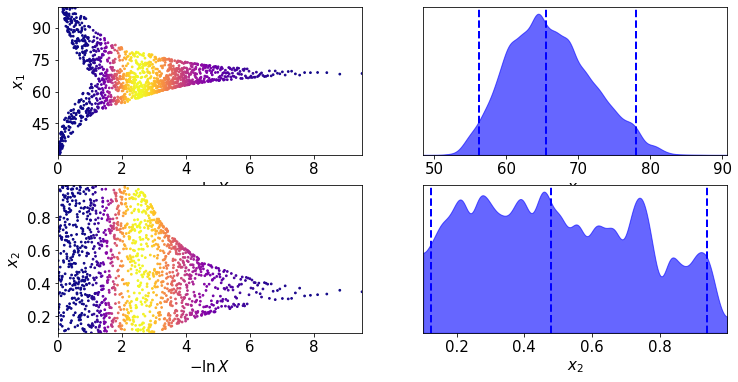

In [19]:
tfig, taxes = dyplot.traceplot(sresults)

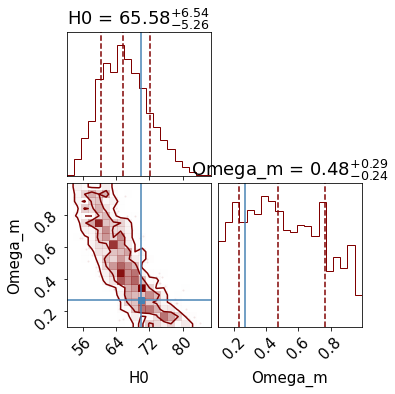

In [20]:
from dynesty import utils as dyfunc
import corner

samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

labels = ["H0", "Omega_m"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels, levels=[0.68,0.95], quantiles =[0.16,0.5,0.84], truths = par_guess, show_titles= True, color = 'maroon');

In [21]:
# Compute 16%-84% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights) for samps in samples.T]
for i,j in zip(np.arange(0,4,1), labels):
    print(j + ": " + str(quantiles[i]) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are:\n ' + str(mean) + '\n' + str(cov))


H0: [60.32540280264002, 72.30120736153292]

Omega_m: [0.2307858676076566, 0.766939874575307]

Mean and covariance of parameters are:
 [66.12062672  0.50271248]
[[33.01651979 -1.15148113]
 [-1.15148113  0.05654899]]


In [22]:
sresults.summary()

Summary
nlive: 300
niter: 1139
ncall: 11012
eff(%): 13.068
logz: -48.877 +/-  0.127


In [23]:
log_probabilites_nested = sresults.logl
max_posterior_idx = np.argmax(log_probabilites_nested)
max_posterior_nested = samples[max_posterior_idx]
print('Constant from the Nested sampling: H0 =  %.2f, Omega_m = %.3f' %(max_posterior_nested[0], max_posterior_nested[1]))

Constant from the Nested sampling: H0 =  68.48, Omega_m = 0.349


(35.0, 50.0)

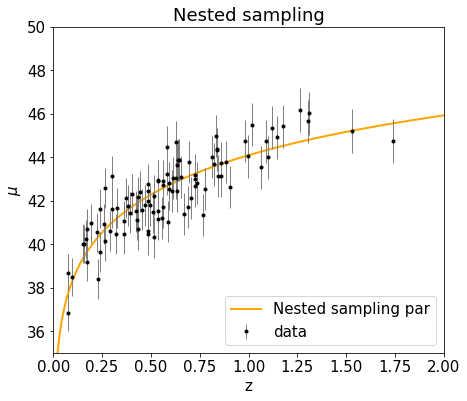

In [24]:
plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['font.size'] = 15

plt.plot(z_grid, distance(z_grid, max_posterior_nested[0], max_posterior_nested[1]),label='Nested sampling par', color = 'orange', linewidth= 2)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.title('Nested sampling')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)


In [25]:
evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))


Bayesian evidence 5.928147975788841e-22


## Comparison of the methods

In [26]:
print('Comparison of H0:')

print('H0 from astropy.cosmology: %.3f' % cosmo.H(0).value)
print('H0 from the Curve fit: %.3f' % popt[0])
print('H0 from the MCMC: %.2f' % max_posterior_mcmc[0])
print('H0 from the Nested sampling: %.2f' % max_posterior_nested[0])

print('\n-----------------\n')

print('Comparison of Omega_m:')
print('Omega_m astropy.cosmology: %.3f' % cosmo.Om0)
print('Omega_m from the Curve fit: %.3f' % popt[1])
print('Omega_m from the MCMC: %.3f' % max_posterior_mcmc[1])
print('Omega_m from the Nested sampling: %.3f' % max_posterior_nested[1])

Comparison of H0:
H0 from astropy.cosmology: 69.320
H0 from the Curve fit: 68.521
H0 from the MCMC: 68.59
H0 from the Nested sampling: 68.48

-----------------

Comparison of Omega_m:
Omega_m astropy.cosmology: 0.286
Omega_m from the Curve fit: 0.345
Omega_m from the MCMC: 0.345
Omega_m from the Nested sampling: 0.349


## Universe without Dark Energy

Now we study the case with a universe with $\Omega_{m} = 1 $ and no $\Lambda$, and see if these few data are an evidence for dark energy existence.

In [27]:
H_min, H_max = 30.0, 100.0

def distance_nodm(z, x):
    H0 = x[0] 
    Universe = LambdaCDM(H0=H0, Om0=1, Ode0=0)
    return Universe.distmod(z).value 

def loglike_nodm(x):
    model = distance_nodm(z_sample, x)
    logL = -0.5*np.sum((mu_sample-model)**2 / dmu**2)
    
    if not np.isfinite(logL):
        logL = -1e300
    
    return logL
 
# Define our uniform prior
def ptform_nodm(u):

    x = scipy.stats.uniform(loc=H_min,scale=H_max-H_min).ppf(u)

    return x

In [28]:
# "Static" nested sampling
ndim = 1
sampler_nodm = dynesty.NestedSampler(loglike_nodm, ptform_nodm, ndim, nlive=300) #nlive = 250 by default
sampler_nodm.run_nested()
sresults_nodm = sampler_nodm.results

1132it [00:26, 42.36it/s, +300 | bound: 1 | nc: 1 | ncall: 11181 | eff(%): 13.161 | loglstar:   -inf < -47.102 <    inf | logz: -49.550 +/-  0.066 | dlogz:  0.001 >  0.309]


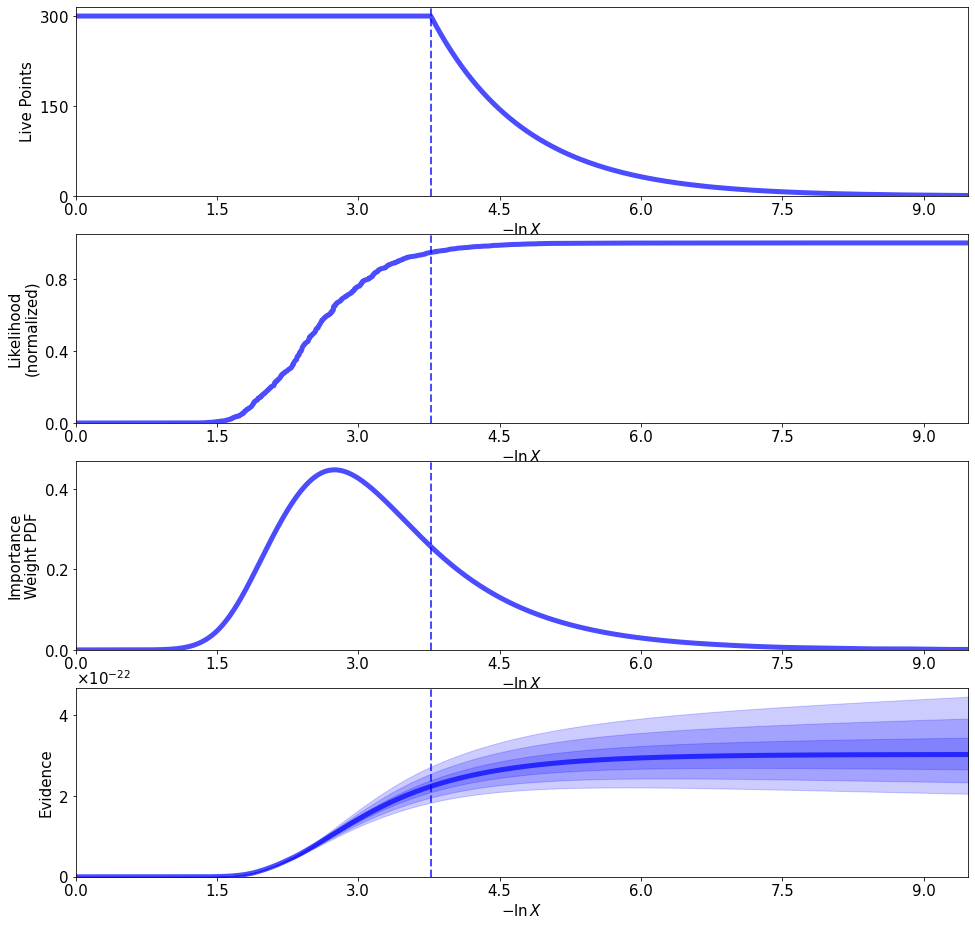

In [29]:
plt.rcParams['figure.figsize'] = [2, 2]
from dynesty import plotting as dyplot
rfig, raxes = dyplot.runplot(sresults_nodm)

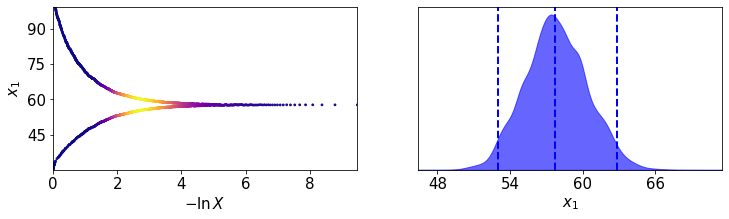

In [30]:
tfig, taxes = dyplot.traceplot(sresults_nodm)

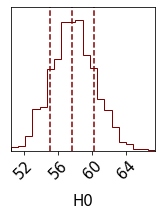

In [31]:
samples_nodm = sresults_nodm.samples  # samples
weights_nodm = np.exp(sresults_nodm.logwt - sresults_nodm.logz[-1])  # normalized weights

labels = ["H0"]

samples_equal_nodm = dyfunc.resample_equal(samples_nodm, weights_nodm)
corner.corner(samples_equal_nodm,labels=labels, levels=[0.68,0.95], quantiles =[0.16,0.5,0.84], truth = par_guess[0], color = 'maroon');

In [32]:
# Compute 16%-84% quantiles.
quantiles_nodm = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_nodm) for samps in samples_nodm.T]
for i,j in zip(np.arange(0,4,1), labels):
    print(j + ": " + str(quantiles_nodm[i]) + '\n')

# Compute weighted mean and covariance.
mean_nodm, cov_nodm = dyfunc.mean_and_cov(samples_nodm, weights_nodm)
print('Mean and covariance of parameters are:\n ' + str(mean_nodm) + '\n' + str(cov_nodm))


H0: [55.13086119339915, 60.28024332194365]

Mean and covariance of parameters are:
 [57.78663425]
[[6.51574279]]


In [33]:
sresults.summary()

Summary
nlive: 300
niter: 1139
ncall: 11012
eff(%): 13.068
logz: -48.877 +/-  0.127


In [34]:
log_probabilites_nested_nodm = sresults_nodm.logl
max_posterior_idx_nodm = np.argmax(log_probabilites_nested_nodm)
max_posterior_nested_nodm = samples[max_posterior_idx_nodm]
print('Constant from the Nested sampling: H0 =  %.2f' % max_posterior_nested_nodm[0])

Constant from the Nested sampling: H0 =  68.31


(35.0, 50.0)

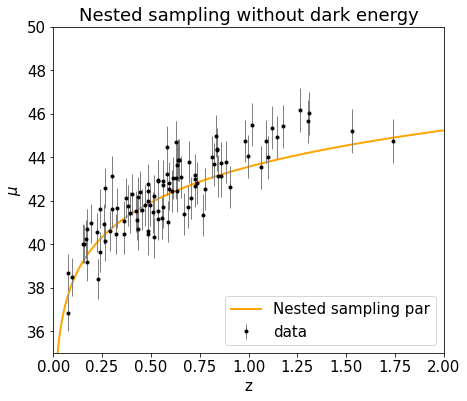

In [35]:
plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['font.size'] = 15

plt.plot(z_grid, distance_nodm(z_grid, max_posterior_nested_nodm),label='Nested sampling par', color = 'orange', linewidth= 2)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.title('Nested sampling without dark energy')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)


In [36]:
evidence = sresults.logz[-1] 
print("Bayesian evidence", np.exp(evidence))
evidence_nodm = sresults_nodm.logz[-1] 
print("Bayesian evidence for no dark energy universe", np.exp(evidence_nodm))
print('The logarithmic Bayes factor is: ', np.log(np.exp(evidence)/np.exp(evidence_nodm)))

Bayesian evidence 5.928147975788841e-22
Bayesian evidence for no dark energy universe 3.025216729759767e-22
The logarithmic Bayes factor is:  0.6727291147419265


The Bayes factor is **inconclusive**. 
Both a universe with DM and a universe with no DM describes our data, we cannot choose a model.


## Savage-Dicky density ratio 

We can consider the two models we compared as models with nested parameter.

M2 = no Dark energy ( $\Omega_{\Lambda} = 0)$ and M1 = Dark Energy ( $\Omega_{\Lambda} \neq 0) $.

The Bayesian factor od the two models can be computed as:

$$ \mathcal{B} = \frac{\mathcal{Z}_2}{\mathcal{Z}_1} = \frac{p(\Omega_{\Lambda}=0)}{p(\Omega_{\Lambda}=0|d,n)}$$.


We estimate the denominator by making an histogram of the posterior sample in $\Omega_{\Lambda}$ and reading off the normalized pdf at $\Omega_{\Lambda} = 0$.

In [228]:
import emcee

H_min, H_max = 30.0, 100.0
Omega_m_min, Omega_m_max = 0.1, 1.0
Omega_l_min, Omega_l_max = -0.5, 1.0

def distance_emcee_sd(z, x):
    H0, Om, Ol= x 
    Universe = LambdaCDM(H0=H0, Om0=Om, Ode0=Ol)
    return Universe.distmod(z).value 

def LogLikelihood_sd(x, z, mu, dmu):   
    if (x[1]<0 or x[2]<0):
        return -np.inf
    else:
        model = distance_emcee_sd(z, x)
        return -0.5*np.sum((mu-model)**2 / dmu**2 + 2*np.log(dmu))


def LogPrior_sd(x):
    H0, Omega_m, Omega_l = x
    if H_min < H0 < H_max and Omega_m_min < Omega_m < Omega_m_max and Omega_l_min < Omega_l < Omega_l_max :
        return 0.0 + 0.0 + 0.0
    else: 
        return -np.inf

def myLogPosterior_sd(x, z, mu, dmu):
    lp = LogPrior_sd(x)
    if not np.isfinite(lp):
        return -np.inf
    else: 
        return LogLikelihood_sd(x, z, mu, dmu) + LogPrior_sd(x)


In [229]:
ndim = 3  # number of parameters in the model
nwalkers = 12  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(6)
par_guess_sd = [70, 0.27, 0.73]
starting_guesses = par_guess_sd + np.random.random((nwalkers, ndim))
sampler_sd = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior_sd, args=[z_sample, mu_sample, dmu])
sampler_sd.run_mcmc(starting_guesses, nsteps, progress = True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler_sd.chain[:, burn:, :].reshape(-1, ndim)

print("done")

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\LEONARDO\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [03:08<00:00, 52.95it/s]

done


In [230]:
tau_sd = sampler_sd.get_autocorr_time()
print(tau_sd)
thin_sd = tau_sd.astype(int) +1 
print(thin_sd)

new_samples_sd = sampler_sd.get_chain(discard=int(burn/max(thin_sd)), thin = max(thin_sd), flat=True)
print(new_samples_sd.shape)

[52.13462524 62.3457707  61.31987962]
[53 63 62]
(1896, 3)


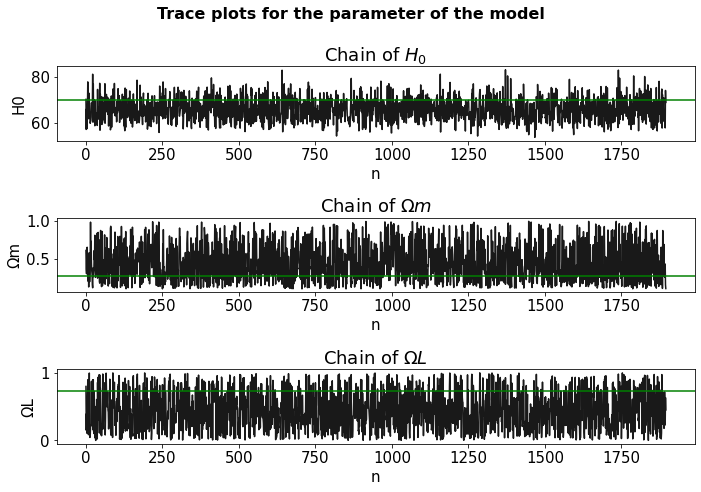

In [231]:
fig, ax= plt.subplots(3, figsize=(10, 7))
ax[0].plot(new_samples_sd[:,0], color='black', alpha = 0.9)
ax[1].plot(new_samples_sd[:,1], color='black', alpha = 0.9)
ax[2].plot(new_samples_sd[:,2], color='black', alpha = 0.9)

#initial guesses lines
ax[0].axhline(par_guess_sd[0], color='green')
ax[1].axhline(par_guess_sd[1], color='green')
ax[2].axhline(par_guess_sd[2], color='green')

fig.suptitle('Trace plots for the parameter of the model', fontsize = 16, fontweight="bold")

ax[0].set_xlabel('n')
ax[0].set_ylabel('H0')
ax[0].set_title('Chain of $H_{0}$')


ax[1].set_xlabel('n')
ax[1].set_ylabel('Ωm')
ax[1].set_title('Chain of $Ωm$')

ax[2].set_xlabel('n')
ax[2].set_ylabel('ΩL')
ax[2].set_title('Chain of $ΩL$')


fig.tight_layout()
plt.show()

Text(0.5, 1.04, 'Corner plot 3-D parameter space')

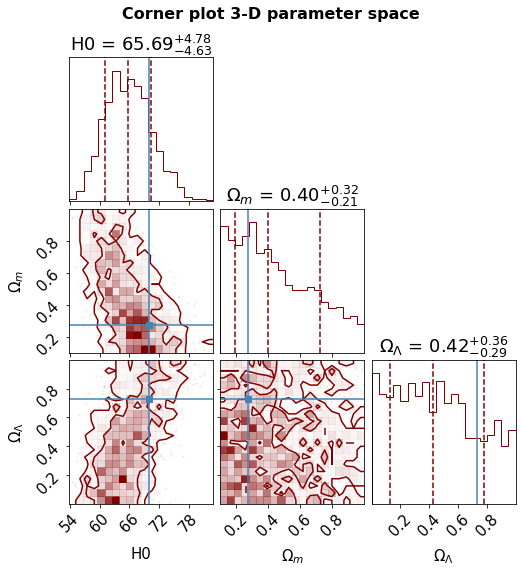

In [232]:
import corner

labels_sd = ["H0", r"$\Omega_{m}$", r"$\Omega_{\Lambda}$" ]
fig = corner.corner(new_samples_sd, labels=labels_sd, levels=[0.68,0.95], quantiles =[0.16,0.5,0.84], show_titles= True, color = 'maroon', truths = par_guess_sd);
fig.suptitle('Corner plot 3-D parameter space', fontsize = 16, fontweight="bold",  y=1.04)

1896
1.3138380195675454


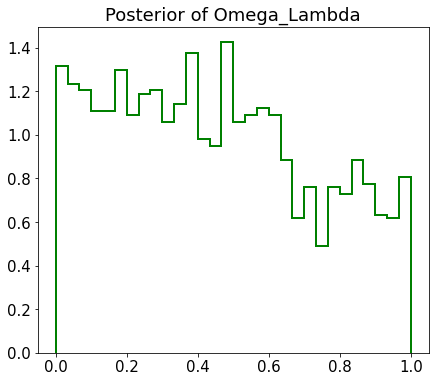

In [233]:
from astropy.visualization.hist import hist as fancyhist
bins = 30
print(len(new_samples_sd[:,2]))
C,bor,_ = fancyhist(new_samples_sd[:,2], bins= bins, histtype="step", lw = 2, color = 'green', density = True) 
plt.title("Posterior of Omega_Lambda") 
print(C[0])

In [235]:
p_omega_0 = C[0]
print('Conditional posterior density at Omega_Lambda = 0 :', p_omega_0 )
B = 1.5 / p_omega_0 
print(B)
print('The logarithmic Bayes factor is: ', np.log(B))


Conditional posterior density at Omega_Lambda = 0 : 1.3138380195675454
1.141693251116093
The logarithmic Bayes factor is:  0.13251246842410505


Even the Bayes factor computed with the Savage-Dickey density ratio is inconclusive. Both a universe with DM and a universe with no DM describes our data, we cannot choose a model.

## Upsample of the data

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.

Think about the pdf of these data in  𝑧
 .
Using both the GPR fit and your latest  Λ
 CDM fit, generate a set of  𝜇
  measurements that respects the statistical properties of the data you were given.

We upsample our redshift value using **Inverse transform sampling**.

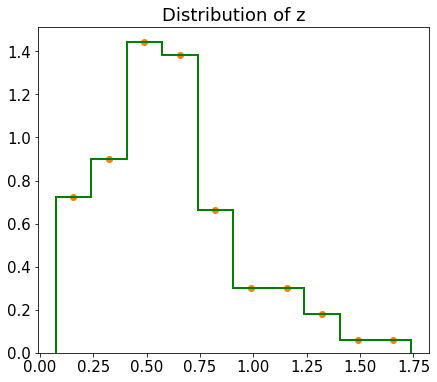

In [115]:
from astropy.visualization.hist import hist as fancyhist
bins = round(np.sqrt(len(z_sample)))
C,bor,_ = fancyhist(z_sample, bins= bins, histtype="step",density=True, lw = 2, color = 'green') 
plt.title("Distribution of z")
cen = (bor[:-1] + bor[1:])/2
plt.scatter(cen, C)

0.12
1.0


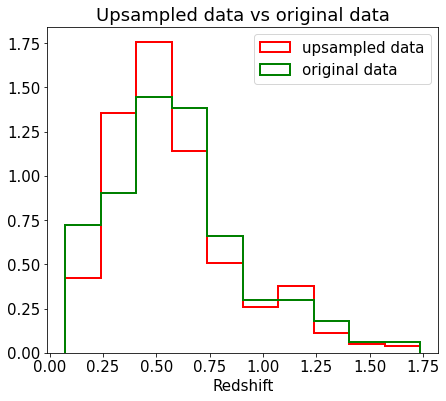

In [116]:
from scipy.interpolate import CubicSpline

Nclone = 1000

cdf = np.cumsum(C) / np.sum(C)
print(min(cdf))
print(max(cdf))

cs = CubicSpline(cdf, cen)
x_up = np.random.uniform(min(cdf),max(cdf),Nclone)
z_upsample = cs(x_up)

plt.hist(z_upsample, density=True, bins= bor,linewidth = 2, histtype='step',color='red',  label = 'upsampled data')
plt.hist(z_sample,bins=bor,density=True,linewidth = 2,histtype='step', label = 'original data', color='green')
plt.legend(loc = 'upper right')
plt.xlabel('Redshift')
plt.title('Upsampled data vs original data')
plt.show()


In [120]:
mu_nested=[]
mu_gpr=[]
for z in z_upsample:
    H0, Om = samples_equal[np.random.choice(samples_equal.shape[0])]
    mu_nested.append(distance(z,H0,Om))
    
    mu_fit, sigma = gp_rb.predict([[z]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit,scale=sigma))

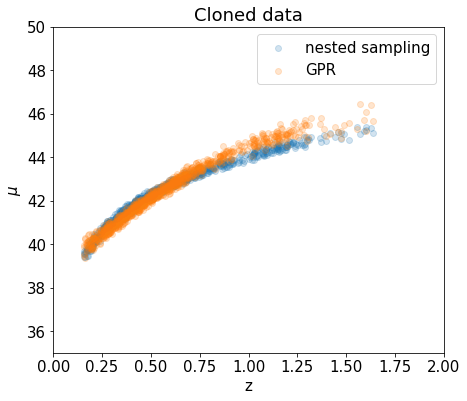

In [121]:
plt.scatter(z_upsample,mu_nested,alpha=0.2,label="nested sampling")
plt.scatter(z_upsample,mu_gpr,alpha=0.2,label='GPR')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title("Cloned data")
plt.legend()